# Productivity Analysis of Open Sources Projects

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import os

from pydriller import RepositoryMining

import matplotlib.pyplot as plt
import ruptures as rpt

In [2]:
# repo = 'openwrt/openwrt'
repo = 'Azure/azure-powershell'
link = f'https://github.com/{repo}'
start = datetime(2021, 3, 1, 0, 0, 0)
end = datetime.now()


### Retrieve Commit Data

In [3]:
commit_data = []

for commit in RepositoryMining(link, since=start, to=end).traverse_commits():
    commit_data.append([commit.committer_date,
                        commit.insertions,
                        commit.deletions,
                        commit.lines,
                        commit.files])

df = pd.DataFrame(data=commit_data, columns=['committer_date', 'insertions', 'deletions', 'lines', 'files'])
df['committer_date'] = pd.to_datetime(df['committer_date'], utc=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/mnt/c/Users/rober/repos/SSW-533/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-82439a994de4>", line 7, in <module>
    commit.insertions,
  File "/mnt/c/Users/rober/repos/SSW-533/env/lib/python3.6/site-packages/pydriller/domain/commit.py", line 564, in insertions
    return self._c_object.stats.total["insertions"]
  File "/mnt/c/Users/rober/repos/SSW-533/env/lib/python3.6/site-packages/git/objects/commit.py", line 280, in stats
    text = self.repo.git.diff(self.parents[0].hexsha, self.hexsha, '--', numstat=True)
  File "/mnt/c/Users/rober/repos/SSW-533/env/lib/python3.6/site-packages/git/cmd.py", line 546, in <lambda>
    return lambda *args, **kwargs: self._call_process(name, *args, **kwargs)
  File "/mnt/c/Users/rob

### Clean & Format

In [4]:
data = df.groupby(pd.Grouper(key='committer_date', freq='1D')).sum()
data.tail()

,insertions,deletions,lines,files
committer_date,,,,
2021-04-28 00:00:00+00:00,30,9,39,4
2021-04-29 00:00:00+00:00,345,5,350,11
2021-04-30 00:00:00+00:00,1171,513,1684,80
2021-05-01 00:00:00+00:00,212,149,361,20
2021-05-02 00:00:00+00:00,5,4,9,2


In [5]:
# Reindex to fill missing days
idx = pd.date_range(data.index[0], data.index[-1])

data.index = pd.DatetimeIndex(data.index)
data = data.reindex(idx, fill_value=0)

In [6]:
data.index = data.index.rename('committer_date')
data.tail()

,insertions,deletions,lines,files
committer_date,,,,
2021-04-28 00:00:00+00:00,30,9,39,4
2021-04-29 00:00:00+00:00,345,5,350,11
2021-04-30 00:00:00+00:00,1171,513,1684,80
2021-05-01 00:00:00+00:00,212,149,361,20
2021-05-02 00:00:00+00:00,5,4,9,2


In [7]:
data.reset_index(inplace=True)

# Re-Group by larger period
data = data.groupby(pd.Grouper(key='committer_date', freq='30D')).sum()
data.tail()

,insertions,deletions,lines,files
committer_date,,,,
2020-12-26 00:00:00+00:00,18905,9206,28111,749
2021-01-25 00:00:00+00:00,146887,20840,167727,2771
2021-02-24 00:00:00+00:00,231562,35133,266695,2374
2021-03-26 00:00:00+00:00,33844,11012,44856,973
2021-04-25 00:00:00+00:00,1764,680,2444,118


### Change Point Detection

In [8]:
# Create 'signal' for change point detection
signal = data.values

n_dims = len(data.columns)
n_bkps = 1

In [9]:
algo = rpt.Dynp(model="l2").fit(signal)
bkps = algo.predict(n_bkps=n_bkps)
bkps[-1] -= 1

In [10]:
bkp_dates = []
for bkp in bkps[0:-1]:
    bkp_dates.append(data.index[bkp])
    print(f'{bkp} | {data.index[bkp]}')

30 | 2020-06-19 00:00:00+00:00


In [11]:
# fig, ax_array = rpt.display(signal, bkps)

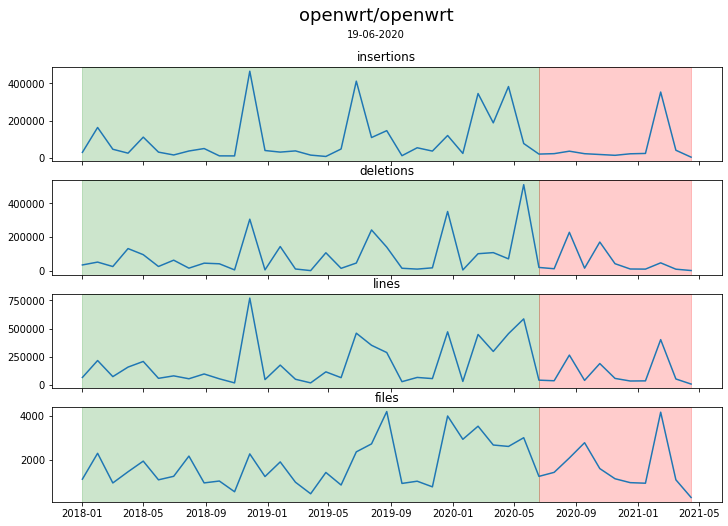

In [12]:
fig, ax = plt.subplots(n_dims, figsize=(12, 8))

for i, col in enumerate(data.columns):
    ax[i].plot(data.index, data[col])
    ax[i].title.set_text(col)
    if i != n_dims - 1:
        plt.setp(ax[i].get_xticklabels(), visible=False)

    prev_bkp = 0
    color = 'green'
    for bkp in bkps:
        start_index, end_index = data.index[prev_bkp], data.index[bkp]
        ax[i].axvspan(start_index, end_index, color=color, alpha=0.2)
        prev_bkp = bkp
        color = 'red' if color == 'green' else 'green' 

plt.text(x=0.5, y=0.96, s=f'{owner}/{repo}', fontsize=18, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.93, s=bkp_dates[0].strftime('%d-%m-%Y'), fontsize=10, ha="center", transform=fig.transFigure)

plt.show()


In [1]:
data.plot()

NameError: name 'data' is not defined

In [2]:
GITHUB = 'https://github.com'

def repo_data(repo, start, end):
    commit_data = []
    count = 0
    for commit in RepositoryMining(f'{GITHUB}/{repo}', since=start, to=end).traverse_commits():
        commit_data.append([
            commit.committer_date,
            commit.insertions,
            commit.deletions,
            commit.lines,
            commit.files
        ])
        count += 1
    df = pd.DataFrame(data=commit_data, columns=['committer_date', 'insertions', 'deletions', 'lines', 'files'])
    df['committer_date'] = pd.to_datetime(df['committer_date'], utc=True)

    return df, count

def change_point_detection(data):
    # Create 'signal' for change point detection
    signal = data.values

    n_dims = len(data.columns)
    n_bkps = 1

    algo = rpt.Dynp(model="l2").fit(signal)
    bkps = algo.predict(n_bkps=n_bkps)
    bkps[-1] -= 1

    return bkps

In [3]:
repos = [
        'openwrt/openwrt',
        'microsoft/vcpkg',
        # 'Azure/azure-powershell',
        'google/googletest',
        'Azure/azure-iot-sdk-c',
        'microsoft/TypeScript',
        'nrwl/nx',
        'angular/angular',
        'docker/cli',
        'rust-lang/rust'
    ]
start, end = datetime(2018, 1, 1, 0, 0, 0),  datetime.now()

openwrt/openwrt         | 2020-06-19 00:00:00+00:00 | 10987 commits
microsoft/vcpkg         | 2020-01-21 00:00:00+00:00 | 8202 commits
google/googletest       | 2018-10-29 00:00:00+00:00 | 2231 commits
Azure/azure-iot-sdk-c   | 2018-10-29 00:00:00+00:00 | 1298 commits
microsoft/TypeScript    | 2019-03-29 00:00:00+00:00 | 10924 commits
nrwl/nx                 | 2020-11-17 00:00:00+00:00 | 2838 commits
angular/angular         | 2020-06-20 00:00:00+00:00 | 11628 commits
docker/cli              | 2020-06-19 00:00:00+00:00 | 2443 commits
rust-lang/rust          | 2018-05-31 00:00:00+00:00 | 66476 commits
117027 total commits


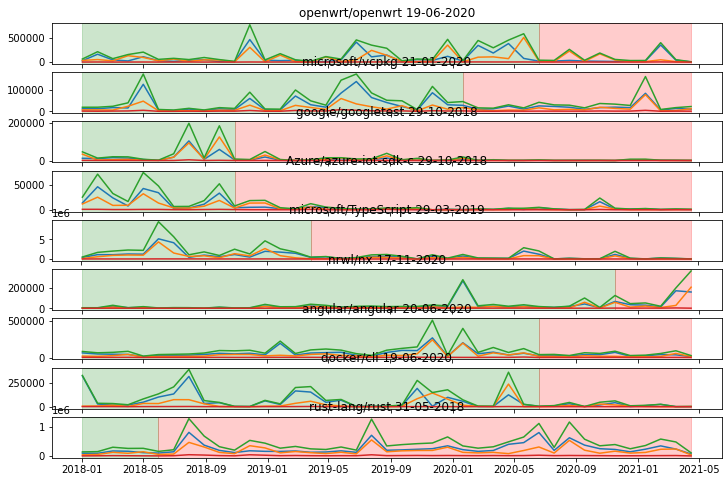

In [4]:
fig, ax = plt.subplots(len(repos), figsize=(12, 8))
commits_total = 0

for i, repo in enumerate(repos):
    data, num_commits = repo_data(repo, start, end)
    commits_total += num_commits

    # Group commits by day
    data = data.groupby(pd.Grouper(key='committer_date', freq='1D')).sum()

    # Reindex to fill missing days
    idx = pd.date_range(data.index[0], data.index[-1])

    data.index = pd.DatetimeIndex(data.index)
    data = data.reindex(idx, fill_value=0)

    # Re-Group by month (30 days)
    data.index = data.index.rename('committer_date')
    data.reset_index(inplace=True)
    data = data.groupby(pd.Grouper(key='committer_date', freq='30D')).sum()

    # Save
    # data.to_csv(os.path.join(os.getcwd(), repo.replace('/', '_')))

    # Run change point detection on data
    try:
        bkps = change_point_detection(data)
        for bkp in bkps[:-1]:
            print(f'{((repo[:20] + "...") if len(repo) > 23 else repo[:23]):<23} | {data.index[bkp]} | {num_commits} commits')
    except:
        print(f'{((repo[:20] + "...") if len(repo) > 23 else repo[:23]):<23} | no breakpoints found')
        continue

    # Add data to plot
    ax[i].title.set_text(f'{repo} {data.index[bkps[0]].strftime("%d-%m-%Y")}')

    for col in data.columns:
        ax[i].plot(data.index, data[col])
    
    # Highlight breakpoints
    prev_bkp, color = 0, 'green'
    for bkp in bkps:
        start_index, end_index = data.index[prev_bkp], data.index[bkp]
        ax[i].axvspan(start_index, end_index, color=color, alpha=0.2)
        prev_bkp = bkp
        color = 'red' if color == 'green' else 'green'

    if i != len(repos) - 1:
        plt.setp(ax[i].get_xticklabels(), visible=False)

print(f'{commits_total} total commits')

plt.show()

In [7]:
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

<Figure size 432x288 with 0 Axes>

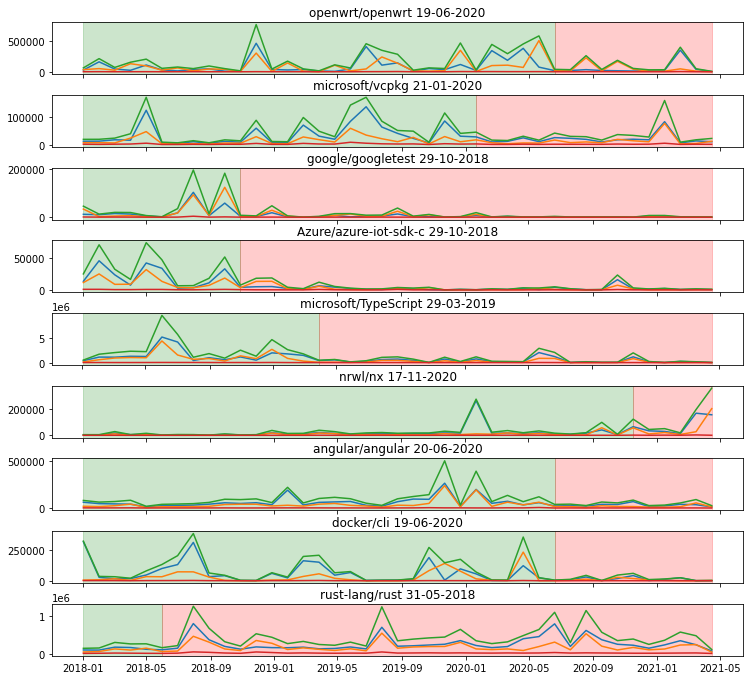

In [20]:
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
fig

### Regression Analysis